In [ ]:
#CODE TO SETUP WANDB
!pip install wandb

import wandb
from wandb.keras import WandbCallback

wandb.login()

In [2]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from sklearn.utils import class_weight, compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from tensorflow.keras.optimizers import Adam

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)


In [34]:
# Reading the Twitter sentiment dataset
dataset = pd.read_csv('Airline_sentiment.csv',encoding = 'ISO-8859-1')
dataset.tail()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
14635,681679794,False,finalized,3,2/25/15 19:46,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2/22/15 12:01,5.695880e+17,NaN,NaN
14636,681679795,False,finalized,3,2/25/15 19:14,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2/22/15 11:59,5.695870e+17,Texas,NaN
14637,681679796,False,finalized,3,2/25/15 19:04,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2/22/15 11:59,5.695870e+17,"Nigeria,lagos",NaN
14638,681679797,False,finalized,3,2/25/15 18:59,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2/22/15 11:59,5.695870e+17,New Jersey,Eastern Time (US & Canada)
14639,681679798,False,finalized,3,2/25/15 19:06,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2/22/15 11:58,5.695870e+17,"dallas, TX",NaN


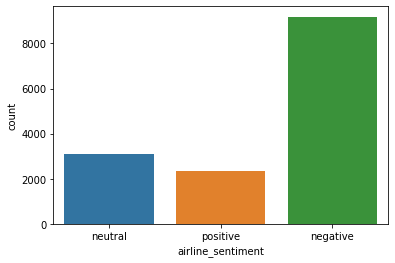

In [35]:
# Airline Twitter sentiment
sns.countplot(data=dataset, x=dataset['airline_sentiment'])
# Sentiment is not very balanced, sadly most of the tweets are negative :(

{'Virgin America': None, 'United': None, 'Southwest': None, 'Delta': None, 'US Airways': None, 'American': None}


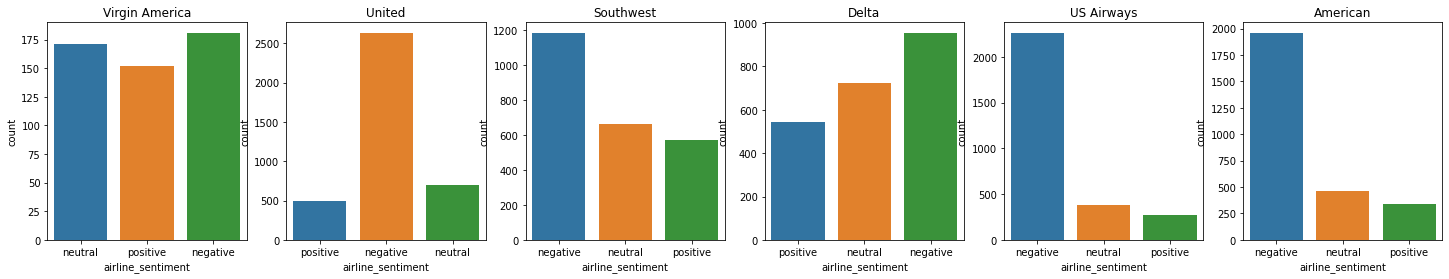

In [36]:
airlines=dataset['airline'].unique()
airlines_datasets=dict.fromkeys(airlines)
print(airlines_datasets)

fig, ax = plt.subplots(1,len(airlines))
fig.set_figwidth(25)
for i in range(len(airlines)):
    sns.countplot(x='airline_sentiment',data=dataset[dataset['airline']==airlines[i]],ax=ax[i]).set_title(airlines[i])
    airlines_datasets[airlines[i]]=dataset[dataset['airline']==airlines[i]]

#Taking a closer look at each airline, it becomes clear who are the more popular airlines

In [38]:
dataset.drop(dataset.columns.difference(['airline_sentiment','text']), 1, inplace=True)

In [39]:
X = dataset.drop(['airline_sentiment'], axis=1)
y = dataset['airline_sentiment']

# Using a tokenizer to convert the text into a sequence of integers
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X.text)
sequences = tokenizer.texts_to_sequences(X.text)

#Add padding to make all sequences the same length
X_encoded = pad_sequences(sequences, maxlen=50, padding='post')

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=3000, random_state=42, stratify=y)

In [40]:
# Loading GloVe 300d word embeddings
embeddings_index = dict()
f = open('glove.6B.300d.txt') # Not included in the github, download manual first
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Number of word vectors loaded: %s' % len(embeddings_index))

Number of word vectors loaded: 400000


In [41]:
# Filtering out words that are not in the GloVe embeddings
vocabulary_size = X_train.max()

embedding_matrix = np.zeros((vocabulary_size+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
         embedding_matrix[i] = embedding_vector

In [42]:
# Categorize the labels
cats=pd.Categorical(y)
y_train=cats.codes

In [43]:
# We noticed earlier that the dataset was unbalanced, so we will use class weights to balance the dataset
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights)),
class_weights=class_weights[0]

In [44]:
class_weights

{0: 0.5317062540858575, 1: 1.5747015166182639, 2: 2.0651713922979265}

In [45]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [51]:
def train_model():
    run = wandb.init(project='airline_sentiment')',
                    config={  # and include hyperparameters and metadata
                        "learning_rate": 0.01,
                        "epochs": 10,
                        "batch_size": 64,
                        "dropoutrate":0.1,
                        "activation_hidden": 'relu' ,
                        "activation_output": 'softmax',
                        "loss_function": "sparse_categorical_crossentropy",
                        "architecture": "LSTM",
                        "dataset": "Sentiment"
                    })
    
    config = wandb.config
    adam = Adam(config.learning_rate)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    model = Sequential()
    #-----------------------------------------------
    model.add(Embedding(vocabulary_size+1, 300, weights=[embedding_matrix], input_length=50, trainable=False))
    model.add(SpatialDropout1D(config.dropoutrate))
    model.add(Bidirectional(LSTM(units = 128,return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))
    model.add(Dropout(config.dropoutrate))
    #-----------------------------------------------
    model.add(Bidirectional(LSTM(units = 64,return_sequences=False)))
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))
    model.add(Dropout(config.dropoutrate))
    #-----------------------------------------------
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation(config.activation_hidden))
    model.add(Dropout(config.dropoutrate))
    model.add(Dense(3, activation=config.activation_output))

    model.compile(loss=config.loss_function,
                optimizer=adam,
                metrics=['accuracy'])

    # Trainen
    history = model.fit(X_train,y_train,batch_size=config.batch_size, epochs=config.epochs,class_weight=class_weights ,validation_split=0.2, verbose=1, callbacks=[WandbCallback(),es])
    loss, accuracy = model.evaluate(X_test, y_test)
    wandb.log({'Test loss': loss, 'Test accuracy': accuracy})
    return model, history,run,checkpoint_filepath

In [ ]:
model, history,run,checkpoint_filepath=train_model()

In [ ]:
sweep_config = {
  'method': 'random', 
  'metric': {
      'name': 'val_loss',
      'goal': 'minimize'
  },
  'parameters': {
      'batch_size': {
          'values': [8, 16, 32, 64, 128, 256]
      },
      'learning_rate':{
          'min': 0.00001,
          'max': 0.1
      },
      'dropoutrate':{
          'values': [0.1, 0.2, 0.3,0.4]
      },
  },
  'early_terminate':{
      'type': 'hyperband',  
      'min_iter': 5
    }
}

sweep_id = wandb.sweep(sweep_config, project="Assignment_5_6_text")
wandb.agent(sweep_id, function=train_model)
# Use sweeps to find the best hyperparameters